In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.decomposition import PCA

In [2]:
# --- 1. LOAD DATA ---
df = pd.read_csv('radial_features_labels.csv')
print(df.head())

   PulseHeight  UpstrokeTime       UpSlope     DownSlope           AUC  \
0  4002.310547         0.176  65929.554688 -40229.789062   8963.785156   
1  5051.110352         0.185  83650.218750 -43199.773438  11134.419922   
2  4445.299805         0.175  70999.859375 -44800.382812  10760.651367   
3  4784.819336         0.178  77899.257812 -45898.636719  10889.458984   
4  5496.000000         0.178  88200.015625 -50700.847656  12815.955078   

   SystTime     cfPWV  
0  0.478499  5.172038  
1  0.520537  5.204386  
2  0.426486  5.413392  
3  0.475502  5.287947  
4  0.471506  5.406001  


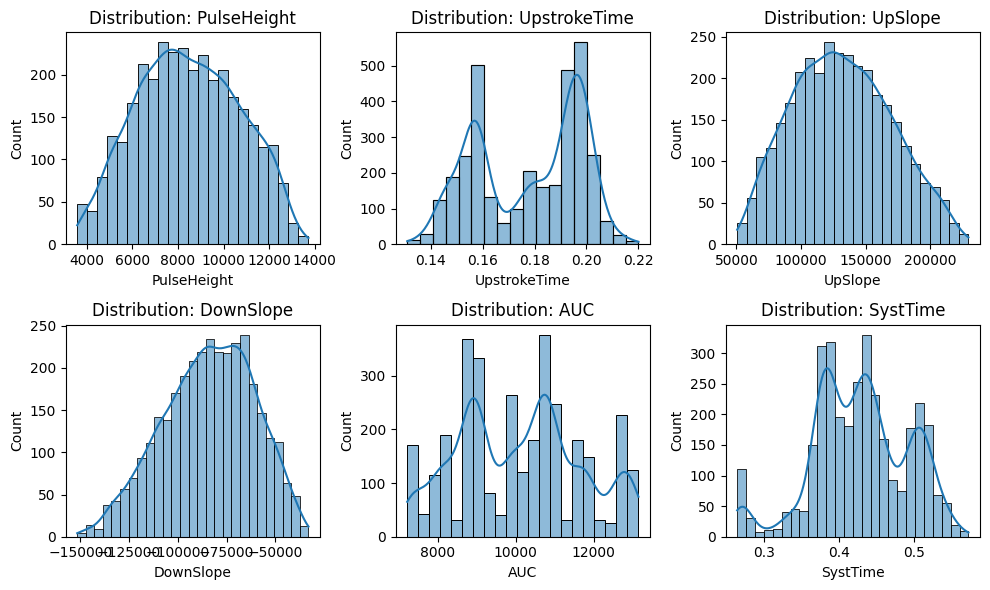

In [3]:
# --- 2. VISUALIZATION: FEATURE DISTRIBUTIONS ---
plt.figure(figsize=(10,6))
for i, col in enumerate(df.columns[:-1]):
    plt.subplot(2,3,i+1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution: {col}')
plt.tight_layout()
plt.show()

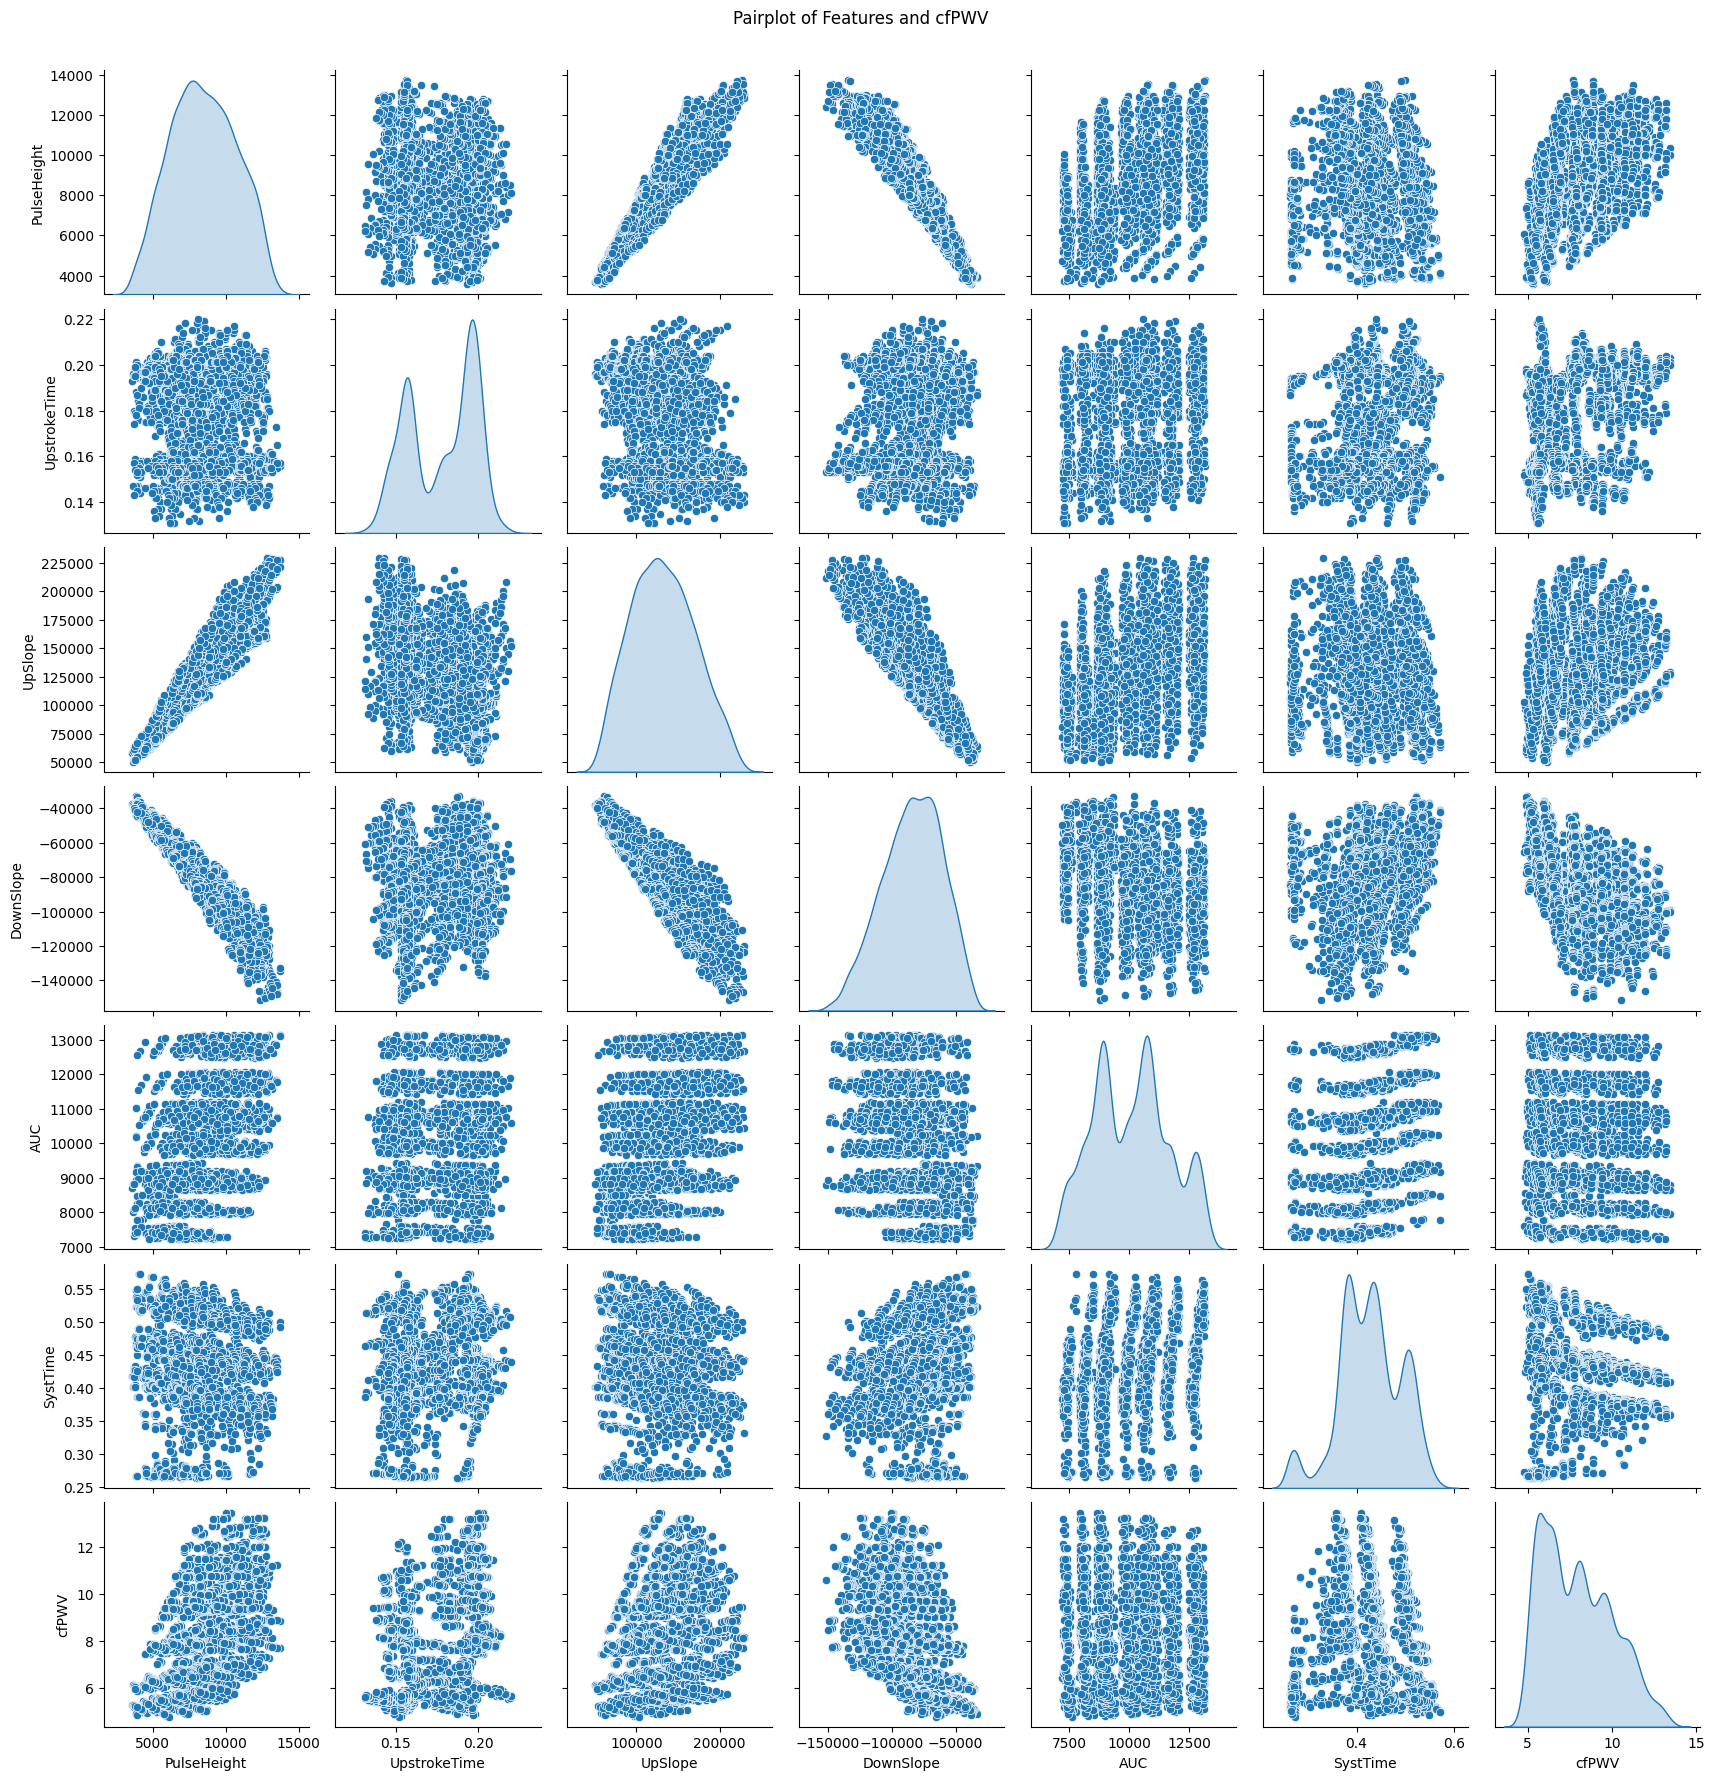

In [4]:
# --- 3. PAIRPLOT: FEATURE RELATIONSHIPS ---
sns.pairplot(df, diag_kind='kde')
plt.suptitle('Pairplot of Features and cfPWV', y=1.02)
plt.show()


In [6]:
# --- 5. ML WORKFLOW ---

# Features and labels
X = df.drop('cfPWV', axis=1)
y = df['cfPWV']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

print(f'R2 score: {r2_score(y_test, y_pred):.3f}')
print(f'Mean Absolute Error: {mean_absolute_error(y_test, y_pred):.3f}')

R2 score: 0.901
Mean Absolute Error: 0.445


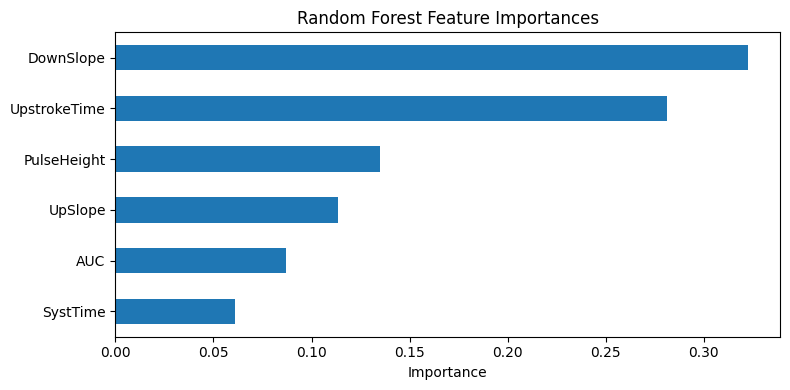

In [7]:
# --- 6. FEATURE IMPORTANCE ---
plt.figure(figsize=(8,4))
feat_imp = pd.Series(model.feature_importances_, index=X.columns)
feat_imp.sort_values().plot(kind='barh')
plt.title('Random Forest Feature Importances')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

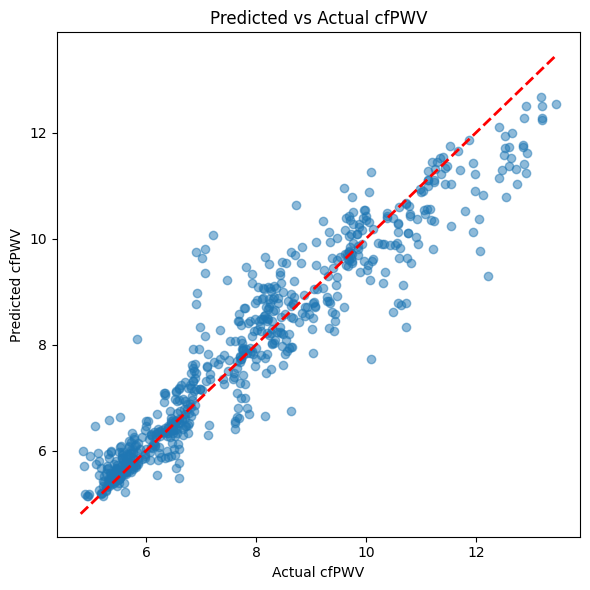

In [8]:
# --- 7. PREDICTED VS ACTUAL PLOT ---
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual cfPWV')
plt.ylabel('Predicted cfPWV')
plt.title('Predicted vs Actual cfPWV')
plt.tight_layout()
plt.show()

In [9]:
# --- 8. PCA VISUALIZATION (OPTIONAL) ---
# If you have waveforms for each subject (e.g., exported from MATLAB)
# Assume you have waveform_data.csv: rows=subjects, cols=time points

try:
    wf = pd.read_csv('waveform_data.csv')  # Not required if you only use features
    pca = PCA(n_components=2)
    wf_pca = pca.fit_transform(wf)
    plt.figure(figsize=(8,6))
    plt.scatter(wf_pca[:,0], wf_pca[:,1], c=df['cfPWV'], cmap='plasma', alpha=0.7)
    plt.colorbar(label='cfPWV')
    plt.xlabel('PC1'); plt.ylabel('PC2')
    plt.title('PCA of Radial Waveforms Colored by cfPWV')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Waveform PCA skipped (export waveform_data.csv if you want this plot)")

Waveform PCA skipped (export waveform_data.csv if you want this plot)


Cross-validated MAE: 0.772 ± 0.144


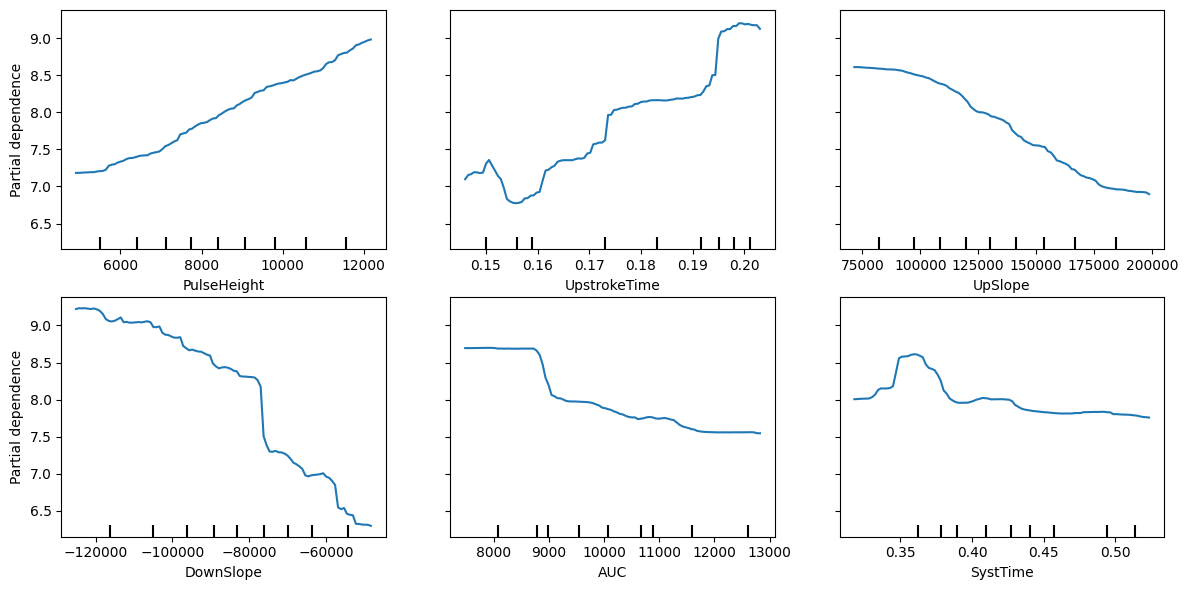

In [10]:
# --- 9. ADVANCED: CROSS-VALIDATION SCORE ---
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
print(f"Cross-validated MAE: {np.mean(-cv_scores):.3f} ± {np.std(cv_scores):.3f}")

# --- 10. OPTIONAL: PARTIAL DEPENDENCE PLOTS (Requires sklearn>=0.24) ---
try:
    from sklearn.inspection import PartialDependenceDisplay
    fig, ax = plt.subplots(figsize=(12, 6))
    PartialDependenceDisplay.from_estimator(
        model, X, features=range(X.shape[1]), feature_names=X.columns, ax=ax
    )
    plt.tight_layout()
    plt.show()
except ImportError:
    print("PartialDependenceDisplay not available in your sklearn version.")
